<a href="https://colab.research.google.com/github/NeuronJay/news_summary/blob/master/IITG_Final_Semantic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook as mentioned uses the sentence embeddings from Universal Sentence Encoder and the various links and third party apps that have been used in the notebook are mentioned thereafter.

Necessary titles and code flow has been explained in the text blocks in the notebook. Apart from that, explanation, logic and other details has been mentioned in the doc file differently. 

In [0]:
# Install the latest Tensorflow version.
!pip3 install --quiet "tensorflow>=1.7"
# Install TF-Hub.
!pip3 install --quiet tensorflow-hub
!pip3 install --quiet seaborn

In [0]:
from absl import logging

import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import nltk
import re
import json

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

The Universal Sentence Encoder encodes text into high dimensional vectors that can be used for text classification, semantic similarity and thus I have tried using it.


In [0]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/3" #@param ["https://tfhub.dev/google/universal-sentence-encoder/2", "https://tfhub.dev/google/universal-sentence-encoder-large/3"]

In [0]:
embed = hub.Module(module_url)

In [0]:
url = 'https://github.com/NeuronJay/news_summary/blob/master/news_summary.csv'
ds = pd.read_csv(url, error_bad_lines=False)

b'Skipping line 78: expected 1 fields, saw 7\nSkipping line 129: expected 1 fields, saw 3\nSkipping line 146: expected 1 fields, saw 9\nSkipping line 147: expected 1 fields, saw 3\nSkipping line 171: expected 1 fields, saw 4\nSkipping line 175: expected 1 fields, saw 2\nSkipping line 177: expected 1 fields, saw 2\nSkipping line 178: expected 1 fields, saw 2\nSkipping line 179: expected 1 fields, saw 2\nSkipping line 180: expected 1 fields, saw 2\nSkipping line 181: expected 1 fields, saw 2\nSkipping line 182: expected 1 fields, saw 2\nSkipping line 183: expected 1 fields, saw 2\nSkipping line 184: expected 1 fields, saw 2\nSkipping line 185: expected 1 fields, saw 2\nSkipping line 186: expected 1 fields, saw 2\nSkipping line 190: expected 1 fields, saw 2\nSkipping line 191: expected 1 fields, saw 2\nSkipping line 197: expected 1 fields, saw 2\nSkipping line 205: expected 1 fields, saw 4\nSkipping line 211: expected 1 fields, saw 2\nSkipping line 216: expected 1 fields, saw 2\nSkipping 

In [0]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 566 entries, 0 to 565
Data columns (total 1 columns):
<!DOCTYPE html>    566 non-null object
dtypes: object(1)
memory usage: 4.5+ KB


In [0]:
def input_feats(text_info):
    if type(text_info) is str:
        text_info = [text_info]
    with tf.Session() as sess:
        sess.run([tf.global_variables_initializer(), tf.tables_initializer()])
        return sess.run(embed(text_info))
    

Eliminating the stopwords 

In [0]:
def rem_stopwords(stop_words, tokens):
    res = []
    for token in tokens:
        if not token in stop_words:
            res.append(token)
    return res

This is the list of contractions and their expanded versions, made by me.

In [0]:
contra = {"y'all": "you all","y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have","ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have"}

The process here used is the find and replace regular expression in the python. Whitespaces, irregular non-text words,symbols have been replaced with white spaces and the expansion-contraction mapping leads to a complete word from the given expression.

In [0]:
def cleanup_text(text):
    text = text.encode('ascii', errors='ignore').decode()
    text = text.lower()
    text = re.sub(r'http\S+', ' ', text)
    text = re.sub(r'#+', ' ', text )
    text = re.sub('"','', text)

    #contra used ( contraction mapping )
    text = ' '.join([contra[t] if t in contra else t for t in text.split(" ")]) 

    text = re.sub(r'@[A-Za-z0-9]+', ' ', text)
    text = re.sub(r"([A-Za-z]+)'s", r"\1 is", text)
    #text = re.sub(r"\'s", " ", text)

    text = re.sub('\W', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip()

    return text

In [0]:
def process_all(text):
    text = cleanup_text(text)
    return ' '.join(rem_stopwords(stop_words, text.split()))

cleanup_text("Hello!! Jay + Dev @ IIT Guwahati !How are you???")

'hello jay dev iit guwahati how are you'

After the process if tokenization is over, I have reduced the words in the specific ergonomic or original form using the WordNetLemmatizer.

In [0]:
def lemmatize_text(tokens):
    lemmatizer = nltk.stem.WordNetLemmatizer()
    lemma_list = []
    for token in tokens:
        lemma = lemmatizer.lemmatize_text(token, 'v')
        if lemma == token:
            lemma = lemmatizer.lemmatize_text(token)
        lemma_list.append(lemma)
    # return [ lemmatizer.lemmatize(token, 'v') for token in tokens ]
    return lemma_list

In [0]:
data = [ """A monopoly is a firm who is the sole seller of its product, and where there are no close substitutes. An unregulated monopoly has market power and can influence prices. Examples: Microsoft and Windows, DeBeers and diamonds, your local natural gas company.""",
    """Pure or perfect competition is a theoretical market structure in which the following criteria are met: All firms sell an identical product (the product is a "commodity" or "homogeneous"). All firms are price takers (they cannot influence the market price of their product). Market share has no influence on prices. """,
   
  """Economics is our relationship with ourselves, 

How we use our time, what we do for leisure, our pace,

Our ratio of being to doing,

Our connection to our passions, our hobbies,

That which we can call our own.

Our locus of control,

Our sense of self-worth, 

Our relationship with time, seasons,

How we define our identity,

Our past, the quality of our present, how we envision our future.

Our freedoms, our constraints,

How we meet our needs,

Our role in society, our mythopoetic identity.

Economics defines and limits our power, our status.

Economics gives us voice, votes.

Economics is our relationship to each other,

Whether we see each other as collaborators or competitors, separate or interconnected.

Economics is our level of trust and the quality of our interactions,

How we manage our housework, our child rearing,

How we care and get cared for,

What we give and what we get,

Economics is our relationship to Earth,

Our connection to land,

Our sense of belonging,

What we build and how we build it,

What and how we eat, where our food comes from, and what happens to our waste.

Whether we see the natural world as a supply house or sewer,

A battlefield or lover,

An animate being or our larger Self.

Economics alienates, subjugates, co-creates, and empowers,

Economics is myth and fact, crisis and opportunity, alive and lifeless,

What is not economics?

Economics is not simply the bottom line, the marketplace, the true cost, or the bank note,

It’s not our first kiss,

Our dreams, 

Our death,

Or the conversations between trees. 

Economics is how we make meaning.""",

    """Sometimes, firms may try to remove uncertainty related to acting independently and enter into price agreements with each other. This is collusion. Collusion is either formal or informal. It can take the form of cartel or price leadership.
A cartel is an association of independent firms within the same industry which follow the common policies relating to price, output, sale, profit maximization, and the distribution of products.
Price leadership is based on informed collusion. Under price leadership, one firm is a large or dominant firm and acts as the price leader who fixes the price for the products while the other firms allow it.""",
   
    """Oligopoly is a market structure with a small number of firms, none of which can keep the others from having significant influence. The concentration ratio measures the market share of the largest firms. A monopoly is one firm, duopoly is two firms and oligopoly is two or more firms.""",
    """At least 400 languages or more than half languages spoken by India's 1.3 billion people may die out in next 50 years, a study by the People's Linguistic Survey of India (PSLI) stated. Further claiming that India has already lost 250 languages in last five decades, the survey said, "Each time a language is lost, the corresponding culture is killed."""
]

Keeping up a tab of the workflow of the things ! 


In [0]:
data_pre = list(map(cleanup_text, data))
len(data_pre)


6

In [0]:
data_pre


['a monopoly is a firm who is the sole seller of its product and where there are no close substitutes an unregulated monopoly has market power and can influence prices examples microsoft and windows debeers and diamonds your local natural gas company',
 'pure or perfect competition is a theoretical market structure in which the following criteria are met all firms sell an identical product the product is a commodity or homogeneous all firms are price takers they cannot influence the market price of their product market share has no influence on prices',
 'economics is our relationship with ourselves how we use our time what we do for leisure our pace our ratio of being to doing our connection to our passions our hobbies that which we can call our own our locus of control our sense of self worth our relationship with time seasons how we define our identity our past the quality of our present how we envision our future our freedoms our constraints how we meet our needs our role in societ

This is the inital trial method taken, where i used the first 200 words of the geven text document.

In [0]:
[d[:200] for d in data_pre ]

['a monopoly is a firm who is the sole seller of its product and where there are no close substitutes an unregulated monopoly has market power and can influence prices examples microsoft and windows deb',
 'pure or perfect competition is a theoretical market structure in which the following criteria are met all firms sell an identical product the product is a commodity or homogeneous all firms are price ',
 'economics is our relationship with ourselves how we use our time what we do for leisure our pace our ratio of being to doing our connection to our passions our hobbies that which we can call our own o',
 'sometimes firms may try to remove uncertainty related to acting independently and enter into price agreements with each other this is collusion collusion is either formal or informal it can take the f',
 'oligopoly is a market structure with a small number of firms none of which can keep the others from having significant influence the concentration ratio measures the market share

I have planned to plot an approximate of the length of the reviews to get an overall idea about the distribution of length of the text.

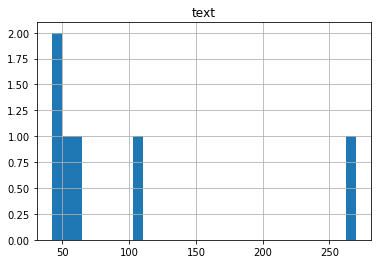

In [0]:
text_word_count = []

for i in data_pre:
      text_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count})

length_df.hist(bins = 30)
plt.show()

In [0]:
cnt=0
for i in data_pre:
    if(len(i.split())<=250):
        cnt=cnt+1
print(cnt/len(data_pre))

0.8333333333333334


We can fix the maximum length of the document as around 250 majority of document summary length.

Assuming the summaries to be one fifth of the sizes.
Thus, the abstractive summaries that can be developed can be fixed at 50.


The BASE_VECTORS representation of text in latent space is required as I need to vectorize the texts.
The length of each vector is 512.
Here the dimension of the vector as shown in below code output. 

There are basic approaches that we get. In order to create a vector that contains the encoding of the sentence,one can concatenate the one-hot vectors for each word. But, the limitation is that there is no relationship between the similarity of any two words and the similarity of their encodings, this feature-weight combination is not meaningful !




In [0]:
BASE_VECTORS = input_feats(data)
BASE_VECTORS.shape


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


(6, 512)

I define cosine similarity to find simiarity between two vectors.

In [0]:
def cosine_similarity(v1, v2):
    mag1 = np.linalg.norm(v1)
    mag2 = np.linalg.norm(v2)
    if (not mag1) or (not mag2):
        return 0
    return np.dot(v1, v2) / (mag1 * mag2)

With the feature extraction of the input text in the form of the vector, I try testing the similarity between the given coded vectors at hand. 

In [0]:
def test_similiarity(text1, text2):
    vc1 = input_feats(text1)[0]
    vc2 = input_feats(text2)[0]
    print(vc1.shape)
    print(vc2.shape)
    return cosine_similarity(vc1, vc2)

The Ranking System used here :

Different embeddings+ Universal sentence encoder by Google 

The model is trained and optimized for greater-than-word length text for example sentences, short paragraphs. 

The input is variable length English text and the output is a 512 dimensional vector. The universal-sentence-encoder model is trained with a deep averaging network (DAN) encoder.

1 is the highest matching ( ideal ) 

Ratios have been given tapped weights accordinly

Checking the working of the individual test similarities. I was having fun with the sentences, bare with the childishness ! :)

In [0]:
test_similiarity("she is my heart throb, she is an angel, I can't live without her", 'i love you')

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


(512,)
(512,)


0.42716095

In [0]:
test_similiarity('he founded that company', 'that company was build by him')

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


(512,)
(512,)


0.9047483

In [0]:
test_similiarity('my name is jay', 'Jay,could you please pass the pizza ?')


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


(512,)
(512,)


0.38704628

I have added the embedding score for the similarity check as asked. I plan to take up a bit of data visualisation in form of heat map and graph and I haven't been able to complete it but the code is here for analysis.

In [0]:
logging.set_verbosity(logging.ERROR)

with tf.Session() as session:
  session.run([tf.global_variables_initializer(), tf.tables_initializer()])
  dataset_embeddings = session.run(embed(data))

  for i, dataset_embedding in enumerate(np.array(dataset_embeddings).tolist()):
    print("Complete Data: {}".format(data[i]))
    print("Embedding size: {}".format(len(dataset_embedding)))
    dataset_embedding_snippet = ", ".join(
        (str(x) for x in dataset_embedding[:3]))
    print("Embedding Score/Ratio: [{}, ...]\n".format(dataset_embedding_snippet))

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Complete Data: A monopoly is a firm who is the sole seller of its product, and where there are no close substitutes. An unregulated monopoly has market power and can influence prices. Examples: Microsoft and Windows, DeBeers and diamonds, your local natural gas company.
Embedding size: 512
Embedding Score/Ratio: [-0.05075870826840401, 0.035883884876966476, 0.10310905426740646, ...]

Complete Data: Pure or perfect competition is a theoretical market structure in which the following criteria are met: All firms sell an identical product (the product is a "commodity" or "homogeneous"). All firms are price takers (they cannot influence the market price of their product). Market share has no influence on prices. 
Embedding size: 512
Embedding Score/Ratio: [-0.017739804461598396, 0.08158218115568161, 0.11002198606729507, ...]

Complete Data: Economics is our relationship with ourselves, 

How we use our time, what we do for leisure, our pace,

Our ratio of being to doing,

Our connection to o

The embeddings produced here by the USE in the Seaborn module approximately normalized.

In [0]:
def graph_similarity(labels, features, rotation):
  corr = np.inner(features, features)
  #sns.set(font_scale=1.5)

  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  
  g.set_xticklabels(labels, rotation=rotation)
  g.set_title("Final Semantic Textual Similarity")

def run_and_plot(session_, input_tensor_, messages_, encoding_tensor):
  dataset_embeddings_ = session_.run(
      encoding_tensor, feed_dict={input_tensor_: messages_})
  graph_similarity(messages_, dataset_embeddings_, 90)

Using the data I defined earlier

In [0]:
def semantic_search(query, datatext, vectors):
    query = cleanup_text(query)
    print("Extracting features...")
    query_vec = input_feats(query)[0].ravel()
    res = []
    for i, d in enumerate(datatext):
        qvec = vectors[i].ravel()
        sim = cosine_similarity(query_vec, qvec)
        res.append((sim, d[:100], i))
    return sorted(res, key=lambda x : x[0], reverse=True)

Running the related searches to find the list of what I have found !

---



In [0]:
semantic_search("An economy (from Greeks an area of the production, distribution and trade, as well as consumption of goods and services by different agents. Understood in its broadest sense, 'The economy is defined as a social domain that emphasize the practices, discourses, and material expressions associated with the production, use, and management of resources'.[1] Economic agents can be individuals, businesses, organizations, or governments.", data_pre, BASE_VECTORS)

Extracting features...
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


[(0.6908423,
  'economics is our relationship with ourselves how we use our time what we do for leisure our pace our',
  2),
 (0.66913086,
  'pure or perfect competition is a theoretical market structure in which the following criteria are me',
  1),
 (0.61725724,
  'sometimes firms may try to remove uncertainty related to acting independently and enter into price a',
  3),
 (0.6168082,
  'oligopoly is a market structure with a small number of firms none of which can keep the others from ',
  4),
 (0.6085885,
  'a monopoly is a firm who is the sole seller of its product and where there are no close substitutes ',
  0),
 (0.26957786,
  'at least languages or more than half languages spoken by india is billion people may die out in next',
  5)]

In [0]:
semantic_search("""Two roads diverged in a yellow wood,
And sorry I could not travel both
And be one traveler, long I stood
And looked down one as far as I could
To where it bent in the undergrowth;

Then took the other, as just as fair,
And having perhaps the better claim,
Because it was grassy and wanted wear;
Though as for that the passing there
Had worn them really about the same,

And both that morning equally lay
In leaves no step had trodden black.
Oh, I kept the first for another day!
Yet knowing how way leads on to way,
I doubted if I should ever come back.

I shall be telling this with a sigh
Somewhere ages and ages hence:
Two roads diverged in a wood, and I—
I took the one less traveled by,
And that has made all the difference.""", data_pre, BASE_VECTORS)

Extracting features...
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


[(0.33185905,
  'economics is our relationship with ourselves how we use our time what we do for leisure our pace our',
  2),
 (0.19125633,
  'a monopoly is a firm who is the sole seller of its product and where there are no close substitutes ',
  0),
 (0.18236053,
  'at least languages or more than half languages spoken by india is billion people may die out in next',
  5),
 (0.18210985,
  'pure or perfect competition is a theoretical market structure in which the following criteria are me',
  1),
 (0.13147734,
  'oligopoly is a market structure with a small number of firms none of which can keep the others from ',
  4),
 (0.075931564,
  'sometimes firms may try to remove uncertainty related to acting independently and enter into price a',
  3)]

In [0]:
semantic_search("We are a consultancy that helps organisations achieve exceptional results by finding and applying practical solutions to complex business and people challenges. We interrupt existing patterns of thinking and instigate powerful, sustainable change.", data_pre, BASE_VECTORS)

Extracting features...
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


[(0.5856607,
  'economics is our relationship with ourselves how we use our time what we do for leisure our pace our',
  2),
 (0.5157189,
  'pure or perfect competition is a theoretical market structure in which the following criteria are me',
  1),
 (0.5058745,
  'sometimes firms may try to remove uncertainty related to acting independently and enter into price a',
  3),
 (0.42066348,
  'oligopoly is a market structure with a small number of firms none of which can keep the others from ',
  4),
 (0.38165754,
  'a monopoly is a firm who is the sole seller of its product and where there are no close substitutes ',
  0),
 (0.27731094,
  'at least languages or more than half languages spoken by india is billion people may die out in next',
  5)]